In this entry, the module identification program is modified to consider the entire Latin alphabet (26 letters) instead of just the 20 used to represent the amino acids. This will allow us to analyze a synthetic sequence made of a single quote translated into different languages to demonstrate the signficance of this method. 

In [1]:
## Import Packages and Define Functions ##
## The only difference between these functions and those in the official version is the list of letters in the 
## get_observed_values() function. It has been expanded to include all 26 Latin characters. Ironically, this should
## still work for protein sequences, they will just all have a count of zero for 6/26 characters.

import random
import timeit
import os
from Bio import SeqIO
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def count_residues_in_sequence(sequence, residue):
    residue_count = 0
    residue_count += sequence.count(residue)
    return residue_count

def get_observed_values(sequence_1, sequence_2):
    obs = np.zeros((2, 26))
    fracsall1 = list()
    for res in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
        count = count_residues_in_sequence(sequence_1, res)
        fraction = count / len(sequence_1)
        fracsall1.append(fraction * 1000)
    obs[0] = fracsall1
    fracsall2 = list()
    for res in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
        count = count_residues_in_sequence(sequence_2, res)
        fraction = count / len(sequence_2)
        fracsall2.append(fraction * 1000)
    obs[1] = fracsall2
    return obs

def get_expected_values(observed_values):
    exp = np.zeros((2,26))
    for seqs in [0,1]:
        for res in range(0,26):
            exp[seqs,res] = (observed_values[0,res]+observed_values[1,res])*0.5
    return exp

def get_residue_conts(observed_values, expected_values):
    conts = np.zeros((2,26))
    for seqs in [0,1]:
        for res in range(0,26):
            if expected_values[seqs,res] == 0:
                conts[seqs,res] = 0
            else:
                conts[seqs,res] = ((observed_values[seqs,res]-expected_values[seqs,res])**2) / expected_values[seqs,res]
    conts_t = conts.transpose()
    res_conts = np.zeros((1,26))
    for res in range(0,26):
        res_conts[0, res] = sum(conts_t[res,:])
    return res_conts

def get_chi_score(residue_conts):
    return residue_conts.sum() / 2000

def calculate_chi_score(sequence_1, sequence_2):
    obs = get_observed_values(sequence_1, sequence_2)
    exp = get_expected_values(obs)
    res_conts = get_residue_conts(obs, exp)
    return get_chi_score(res_conts)
    
def get_heatmap_scores(sequence, window):
    slen = len(sequence)
    nwin = slen - (window - 1)
    seqs = list()
    for windows in range(0, nwin):
        subseq = sequence[windows:windows+window]
        seqs.append(subseq)
    scores = np.zeros((nwin, nwin))
    for x in range(0, nwin):
        for y in range(0, nwin):
            scores[x,y] = calculate_chi_score(seqs[x], seqs[y])
    return(scores)

def get_corr_scores(scores):
    df = pd.DataFrame(scores)
    dfcorr = df.corr()
    corr_scores = dfcorr.to_numpy()
    return corr_scores

## New Instulation Score Definition

def get_insulation_scores(data, ins_window):
    scores = data 
    window_range = np.arange(ins_window, len(scores)-(ins_window), 1)
    insulation_scores = list()
    for x in window_range:
        windowa = list()
        windowb = list()
        if x == window_range[0]:
            for y in np.arange(1, ins_window+1, 1):
                windowa.append(scores[x-y,x+y])
            insulation_scores.append(np.mean(windowa))
        else:
            for y in np.arange(0, ins_window, 1):
                windowa.append(scores[x-y-1, x+y])
            insulation_scores.append(np.mean(windowa))
            for y in np.arange(1, ins_window+1, 1):
                windowb.append(scores[x-y, x+y])
            insulation_scores.append(np.mean(windowb))   
    return insulation_scores

def ins_to_residues(ins_numbers, chi_window):
    residues = list()
    for ins in ins_numbers:
        residues.append(ins+((chi_window-1)/2))
    return residues

def get_region_scores(sequence, optimized_nodes):
    boundaries = [0]
    for node in optimized_nodes:
        if int(node) not in boundaries:
            boundaries.append(int(node))
    boundaries.append(len(sequence))
    if len(boundaries) == 2:
        return 0
    else:
        nregions = len(boundaries) - 1
        regions = list()
        for region in range(0, nregions):
            regions.append(sequence[boundaries[region]:boundaries[region + 1]])
        scores = list()
        for x in range(0, nregions):
            for y in range(0, nregions):
                if y == x - 1:
                    if len(regions[x]) < 1 or len(regions[y]) < 1:
                        scores.append(0)
                    else:
                        scores.append(calculate_chi_score(regions[x], regions[y]))
        return scores
    
def get_modules(sequence, boundaries):
    bounds = [0]
    for bound in boundaries:
        bounds.append(bound)
    bounds.append(len(sequence))
    modules = list()
    for x in np.arange(1, len(bounds), 1):
        modules.append(sequence[int(bounds[x-1]):int(bounds[x])])
    return modules

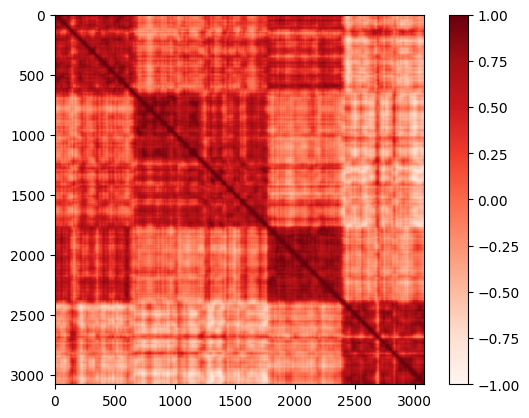

In [9]:
pm_eng = 'ALLADVANCESOFSCIENTIFICUNDERSTANDINGATEVERYLEVELBEGINWITHASPECULATIVEADVENTUREANIMAGINATIVEPRECONCEPTIONOFWHATMIGHTBETRUEAPRECONCEPTIONTHATALWAYSANDNECESSARILYGOESALITTLEWAYSOMETIMESALONGWAYBEYONDANYTHINGWHICHWEHAVELOGICALORFACTUALAUTHORITYTOBELIEVEINITISTHEINVENTIONOFAPOSSIBLEWORLDOROFATINYFRACTIONOFTHATWORLDTHECONJECTUREISTHENEXPOSEDTOCRITICISMTOFINDOUTWHETHERORNOTTHATIMAGINEDWORLDISANYTHINGLIKETHEREALONESCIENTIFICREASONINGISTHEREFOREATALLLEVELSANINTERACTIONBETWEENTWOEPISODESOFTHOUGHTADIALOGUEBETWEENTWOVOICESTHEONEIMAGINATIVEANDTHEOTHERCRITICALADIALOGUEASIHAVEPUTITBETWEENTHEPOSSIBLEANDTHEACTUALBETWEENPROPOSALANDDISPOSALCONJECTUREANDCRITICISMBETWEENWHATMIGHTBETRUEANDWHATISINFACTTHECASE'
pm_spa = 'TODOSLOSAVANCESDELACOMPRENSIONCIENTIFICAATODOSLOSNIVELESCOMIENZANCONUNAAVENTURAESPECULATIVAUNAPRECONCEPCIONIMAGINATIVADELOQUEPODRIASERCIERTOUNAPRECONCENPCIONQUESIEMPREYNECESARIAMENTEVAUNPOCOAVECESMUCHOMASALLADECUALQUIERCOSAENLAQUETENGAMOSAUTORIDADLOGICAOFACTUALPARACREERESLAINVENCIONDEUNMUNDOPOSIBLEODEUNAPEQUENAFRACCIONDEESEMUNDOACONTINUACIONLACONJETURASESOMETEACRITICAPARAAVERGUARSIESEMUNOIMAGINADOSEPARECEONOALREALELRAZONAMIENTOCIENTIFICOESPORTANTOATODOSLOSNIVELESUNAINTERACCIONENTREDOSEPISODIESDELPENSAMIENTOUNDIALOGOENTREDOSVOCESUNAPROPUESTAYLADISPOSICIONLACONJETURAYLACRITICAENTRELOQUEPODRIASERCIERTOYLOQUEDEHECHOESELCASO'
pm_pol = 'WSZYSTKIEPOSTEPYWNAUKOWYMZROZUMIENIUNAKAZDYMPOZIOMIEZACZYNAIASIEODSPEKULATYWNEIPRZYGODYWYOBRAZENIATEGOCOMOZEBYCPRAWDAWYOBRAZENIAKTOREZAWSZEIZKONIECZNOSCIWYKRACZANIECOCZASEMDALEKOPOZAWSZYSTKOWCOMAMYLOGICZNYLUBFAKTYCZNYAUTORYTETBYWIERZYCJESTTOWYMYSLENIEMOZLIWEGOSWIATALUBMALEGOULAMKATEGOSWIATADOMYSLJESTNASTEPNIEPODDAWANYKRYTYCEABYDOWIEDZIECSIECZYTENWYOBRAZONYSWIATJESTWOGOLEPODOBNYDORZECZYWISTEGOROZUMOWANIENAUKOWEJESTWIECNAWSZYSTKICHPOZIOMACHINTERAKCJAMIEDZYDWOMAODCINKAMIMYSLIDIALOGIEMMIEDZYDWOMAGLOSAMIJEDNYMWYOBRAZENIOWYMIDRUGIMKRYTYCZNYMDIALOGIEMJAKTOOKRESLILEMMIEDZYTYMCOMOZLIWEATYMCORZECZYWISTEMIEDZYPROPOZYCIAADYSPOZYCIAPRZYPUSZCZENIEMAKRYTYKAMIEDZYTYMCOMOZEBYCPRAWDAATYMCOJESTNIAWRZECZYWISTOSCI'
pm_jap = 'KAGAKUTEKIRIKAINOSHINPOWAARAYURUREBERUNIOITESUISOKUNOBOKENTSUMARINANIGASHINJITSUDEARUKAMOSHIRENAITOIUSOZOSENNYUKANKARAHAJIMARIMASUSOREWAKANOSEINOARUSEKAIARUIHASONOSEKAINOGOKUICHIBUNOHATSUMEIDESUSOSHITESONOSUISOKUWAHIHANNISARASARESONOSOZONOSEKAIGAGENJITSUNOSEKAITONITEIRUKADOKAGASHIRABERARERUKAGAKUTEKISUIRONTOWAARAYURUREBERUNIOITETSUNOSHIKONOEPISODOKANNOSOGOSAYODEARIIPPOWASOZOTEKITAHOWAHIHANTEKINATSUNOKOENOMANOTAIWADEARIWATASHIGAITTAYONIKANOSEITOJISSAITEIANTOSHOBUNSUISOKUTOHIHANSHINJITSUKAMOSHIRENAIKOTOTOJISSAINISODEARUKOTONOMANOTAIWADEARU'
pm_yor = 'GBOGBOAWONILOSIWAJUTIOYEIJINLESAYENSINIGBOGBOIPELEBEREPELUIRINAROSOISAJUISAJUTIOHUNTIOLEJEOTITOISAJUTINIGBAGBOGBOATIDANDANLOONADIENGBAKUGBAONAPIPEKOJAOHUNKOHUNTIANIOGBONTABIASEOTITOLATIGBAGBOOJEEDATIAYETIOSEESETABITIIDAKANTIAYEYENIRORONAALENINNAFARAHANSIIBAWILATIWABOYATABIKIISEPEAYETIONIEROJEOHUNKOHUNBIITIGIDIAWONEROIMOEROJENITORINANIGBOGBOAWONIPELEIBARAENISEPOLAARINAWONISELEMEJITIEROIJIROROLAARINAWONOHUNMEJIOKANTIONIIMORANATIEKEJIPATAKIIBARAENISOROKANBIMOTIFISIILAARINAWONTIOSEESEATOTITOLAARINIMORANATSISONUISEDUROATIIBAWILAARINOHUBTIOLEJEOTITOATIOHUNOJEOTITO'

pm_full = ''.join([pm_eng, pm_jap, pm_yor, pm_spa, pm_pol])

hm_raw = get_heatmap_scores(pm_full, 51)
hm_corr = get_corr_scores(hm_raw)
hm = plt.imshow(hm_corr, cmap = 'Reds', norm=plt.Normalize(-1, 1))
plt.colorbar(hm)

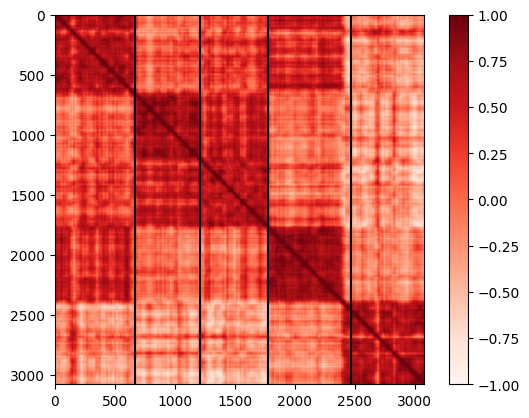

In [18]:
hm = plt.imshow(hm_corr, cmap = 'Reds', norm=plt.Normalize(-1, 1))
plt.colorbar(hm)

for x in [695, 1238, 1802, 2492]:
    plt.axvline(x-25, color='black')

plt.savefig('C:\\Users\\bmcco\\Desktop\\Chi_score\\Fig1 SVGs\\PMquoteUS_1175.svg')